# 링거 투약에 의한 약의 혈중 농도

마쓰우라 겐타로의 데이터 분석을 위한 베이지안 통계 모델링(길벗)의 8.3절 비선형 모델의 계층 문제를 rstan으로 분석한다. 데이터는 환자 16명의 시간에 따른 약의 혈중 농도 데이터이며 개인차를 고려하여 베이지안 회귀를 수행한다.

In [5]:
library(tidyverse)
library(rstan)

tbl <- read_csv("https://raw.githubusercontent.com/MatsuuraKentaro/RStanBook/master/chap08/input/data-conc-2.txt")
tbl

Parsed with column specification:
cols(
  PersonID = col_double(),
  Time1 = col_double(),
  Time2 = col_double(),
  Time4 = col_double(),
  Time8 = col_double(),
  Time12 = col_double(),
  Time24 = col_double()
)



PersonID,Time1,Time2,Time4,Time8,Time12,Time24
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2.4,5.0,7.5,11.9,12.5,12.7
2,1.4,3.9,4.4,7.7,6.4,8.3
3,5.2,9.4,19.4,20.2,22.7,24.9
4,6.7,12.6,19.1,23.4,25.8,26.1
5,0.3,4.7,7.0,10.2,12.9,14.8
6,6.3,3.8,11.8,9.2,13.9,18.2
7,3.0,4.2,8.8,15.4,10.7,16.2
8,6.2,6.8,9.4,11.3,12.4,14.7
9,14.4,17.0,22.7,29.8,33.0,32.2


## tidy data

In [6]:
tbl <- tbl %>%
  mutate(PersonID = as.integer(PersonID)) %>%
  pivot_longer(-PersonID, names_to = "time", values_to = "value") %>%
  mutate(hour = str_sub(time, 5, -1),
         hour = as.double(hour)) %>%
  select(-time)
tbl[1:5,]

PersonID,value,hour
<int>,<dbl>,<dbl>
1,2.4,1
1,5.0,2
1,7.5,4
1,11.9,8
1,12.5,12


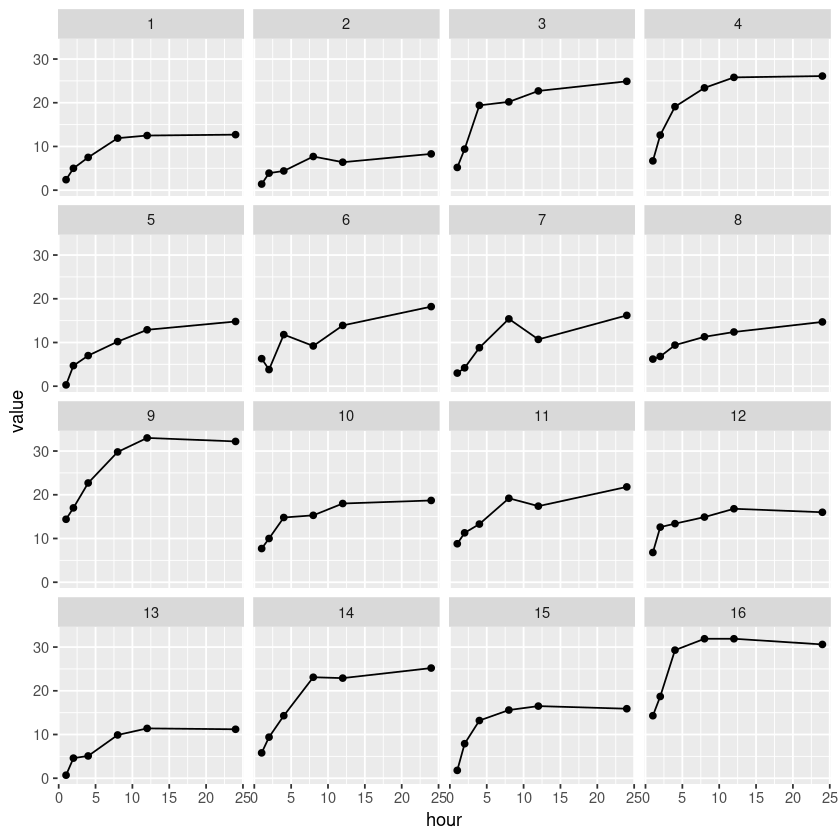

In [7]:
tbl %>%
  ggplot(aes(x = hour, y = value, group = PersonID)) +
  geom_point() +
  geom_line() +
  facet_wrap(~PersonID)

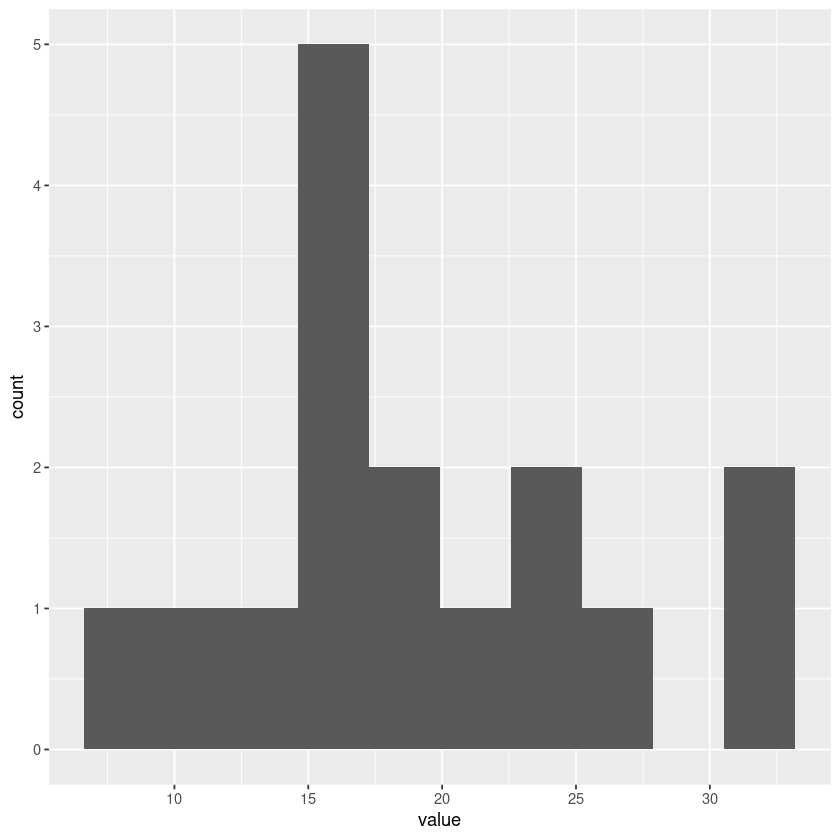

In [8]:
tbl %>%
  filter(hour == 24) %>%
  ggplot(aes(x = value)) +
  geom_histogram(bins = 10)

* 24시간 경과 시점에서 혈중 농도는 개인차가 상당히 큰 것을 확인할 수 있다.

## Stan analysis

참고 문서의 모델과 코드를 대부분 그대로 사용한다. tidy data를 염두에 두지 않고 만든 코드로 향후 수정이 필요하다.

In [9]:
stan_code <- "
data {
  int N;
  int T;
  real Time[T];
  real Y[N, T];
  int T_new;
  real Time_new[T_new];
}

parameters {
  real a0;
  real b0;
  real log_a[N];
  real log_b[N];
  real<lower=0> s_a;
  real<lower=0> s_b;
  real<lower=0> s_Y;
}

transformed parameters {
  real a[N];
  real b[N];
  for (n in 1:N) {
    a[n] = exp(log_a[n]);
    b[n] = exp(log_b[n]);
  }
}

model {
  for (n in 1:N) {
    log_a[n] ~ normal(a0, s_a);
    log_b[n] ~ normal(b0, s_b);
  }
  for (n in 1:N) {
    for (t in 1:T) {
      Y[n, t] ~ normal(a[n] * (1 - exp(-b[n] * Time[t])), s_Y);
    }
  }
}

generated quantities {
  real y_new[N, T_new];
  for (n in 1:N) {
    for (t in 1:T_new) {
      y_new[n, t] = normal_rng(a[n] * (1 - exp(-b[n] * Time_new[t])), s_Y);
    }
  }
}
"

Time <- c(1, 2, 4, 8, 12, 24)
Time_new <- seq(from = 1, to = 24, length = 24)
dat <- tbl %>%
  pivot_wider(names_from = hour, values_from = value)

stan_data <- list(N = 16, T = length(Time), Time = Time, Y = dat[, -1],
                  T_new = length(Time_new), Time_new = Time_new)
fit <- stan(model_code = stan_code, data = stan_data)
y_new  <- rstan::extract(fit)$y_new


SAMPLING FOR MODEL '510151a41b95991b1ead630bdfc86ed1' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 2.9e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.29 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.281512 seconds (Warm-up)
Chain 1:                0.233572 seconds (Sampling)


In [12]:
extract_recode <- function(y_new, n, t) {
  q <- quantile(y_new[, n, t], c(0.025, 0.975))
  list(PersonID = n, hour = t, lower = q[[1]], upper = q[[2]])
}

tbl_y <- tibble(PersonID = integer(), hour = integer(), lower = numeric(), upper = numeric())
for (n in 1:16) {
  for (t in 1:24) {
    tbl_y <- tbl_y %>% add_row(as_tibble(extract_recode(y_new, n, t)))
  }
}
tbl_y[1:5,]

PersonID,hour,lower,upper
<int>,<int>,<dbl>,<dbl>
1,1,-0.5580972,6.497805
1,2,1.6191386,8.923035
1,3,3.2967814,10.729268
1,4,4.5318355,12.136851
1,5,5.5591465,13.181285


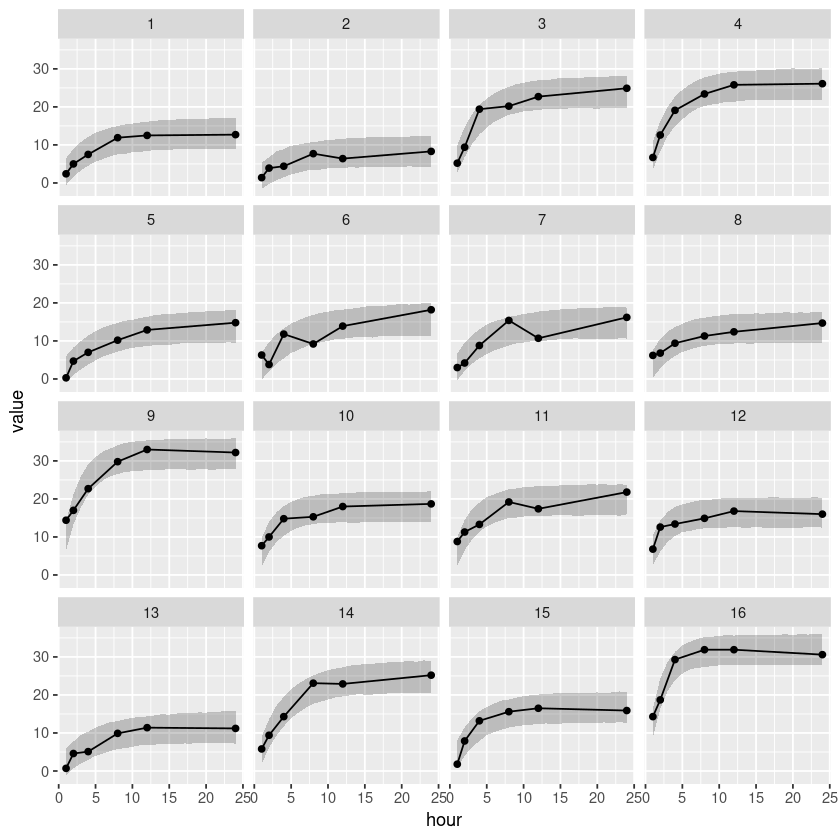

In [13]:
tbl_y %>%
  ggplot(aes(x = hour, group = PersonID)) +
  geom_ribbon(aes(ymin = lower, ymax = upper), fill = 'black', alpha = 0.2) +
  geom_point(data = tbl, aes(x = hour, y = value, group = PersonID)) +
  geom_line(data = tbl, aes(x = hour, y = value, group = PersonID)) +
  facet_wrap(~PersonID)